In [7]:
from pytube import Playlist, YouTube
from pydub import AudioSegment
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

def download_video(url):
    try:
        video = YouTube(url)
        stream = video.streams.filter(only_audio=True).first()
        file_path = stream.download(filename=f"{video.title}.mp4")
        print(f"{video.title} is downloaded in WAV format")
        try:
            audio = AudioSegment.from_file(file_path, format="mp4")
        except FileNotFoundError:
            print("Error: File not found")
            return
        if len(audio) < 6 * 60 * 1000:
            print("The audio is less than 6 minutes long.")
            os.remove(file_path)
            return
        start_time = 3 * 60 * 1000  # Convert 3 minutes to milliseconds
        end_time = len(audio) - (3 * 60 * 1000)
        trimmed_audio = audio[start_time:end_time]
        # Save trimmed audio directly to Google Drive
        trimmed_file_path = f"/content/drive/My Drive/{video.title}_trimmed.wav"
        trimmed_audio.export(trimmed_file_path, format="wav")
        print(f"Trimmed audio saved as {trimmed_file_path}")
    except KeyError:
        print("Unable to fetch video information. Please check the video URL or your network connection.")

URL_PLAYLIST = "https://www.youtube.com/playlist?list=PLDIi15G94GVcBm8fN0l3q1wC823gn6MWf"

# Retrieve URLs of videos from playlist
playlist = Playlist(URL_PLAYLIST)
print('Number Of Videos In playlist: %s' % len(playlist.video_urls))

urls = []
for url in playlist:
    urls.append(url)
    download_video(url)

for i, url in enumerate(urls):
    if i < 28:
        continue
    print(f"Downloading video {i+1} of {len(urls)}")
    print(url)
    download_video(url)
    print("\n\n")
print(urls)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number Of Videos In playlist: 4
نشرة إيجاز - مظاهرات متزايدة في الجامعات الأمريكية دعما لغزة is downloaded in WAV format
The audio is less than 6 minutes long.
انتقادات واسعة ضد رئيسة جامعة كولومبيا نعمت شفيق لاستدعائها الشرطة للحرم الجامعي is downloaded in WAV format
The audio is less than 6 minutes long.
شاهد | كلمة الناطق العسكري باسم كتائب القسام أبو عبيدة في اليوم الـ200 للحرب على غزة is downloaded in WAV format
Trimmed audio saved as /content/drive/My Drive/شاهد | كلمة الناطق العسكري باسم كتائب القسام أبو عبيدة في اليوم الـ200 للحرب على غزة_trimmed.wav
مواجهة على الجليد is downloaded in WAV format
Trimmed audio saved as /content/drive/My Drive/مواجهة على الجليد_trimmed.wav
['https://www.youtube.com/watch?v=hnNZckwSshY', 'https://www.youtube.com/watch?v=cAg6gBUuq6Y', 'https://www.youtube.com/watch?v=lWmOED0eSfI', 'https://www.youtube.com/watch?v=SGoergv9

In [2]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install pytube


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.7 MB/s eta 0:00:00


In [3]:
!pip install pydub

In [4]:
!pip install tensorflow_io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 12.2 MB/s eta 0:00:00


In [ ]:
import librosa
import numpy as np
from natsort import natsorted
import os
import cv2
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

X = []
y_labels = []

path = '/content/drive/MyDrive/embeddings/segmented/'
dialects = natsorted(os.listdir(path))
print(dialects)

for i, dialect in enumerate(dialects):
    full_path = os.path.join(path, dialect)
    audios = natsorted(os.listdir(full_path))
    for j, audio in enumerate(audios):
        wav_file = os.path.join(full_path, audio)
        try:
            # Load the audio file
            y, sr = librosa.load(wav_file, sr=None)
            if y.size == 0:
                raise ValueError("Empty audio file: {}".format(wav_file))
            # Extract Mel spectrogram
            mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
            mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
            # Resize the spectrogram to fit DenseNet input shape
            resized_spec = cv2.resize(mel_spectrogram_db, (224, 224))
            # Stack the spectrogram to create 3 channels
            spectrogram_3d = np.stack((resized_spec,) * 3, axis=-1)
        except Exception as e:
            print("ERROR:", dialect, "AUDIO:", audio)
            print("Exception:", e)
            print("CONTINUING...")
            continue
        y_labels.append(i)
        X.append(spectrogram_3d)
        print("DIALECT:", dialect, "AUDIO:", audio)
    print("FINISHED DIALECT:", dialect)
print(y_labels)
# Load pre-trained DenseNet201 model without the top classification layer
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom top layers for audio classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(dialects), activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model (assuming you have X_train and y_train)
model.fit(np.array(X), np.array(y_labels), epochs=10, batch_size=32, validation_split=0.2)

# Save the model
model.save('audio_densenet_model.h5')


['fos7a', 'masry']
DIALECT: fos7a AUDIO: شاهد | كلمة الناطق العسكري باسم كتائب القسام أبو عبيدة في اليوم الـ200 للحرب على غزة_trimmed.wav_segment_1.wav
DIALECT: fos7a AUDIO: شاهد | كلمة الناطق العسكري باسم كتائب القسام أبو عبيدة في اليوم الـ200 للحرب على غزة_trimmed.wav_segment_2.wav
DIALECT: fos7a AUDIO: شاهد | كلمة الناطق العسكري باسم كتائب القسام أبو عبيدة في اليوم الـ200 للحرب على غزة_trimmed.wav_segment_3.wav
DIALECT: fos7a AUDIO: شاهد | كلمة الناطق العسكري باسم كتائب القسام أبو عبيدة في اليوم الـ200 للحرب على غزة_trimmed.wav_segment_4.wav
DIALECT: fos7a AUDIO: شاهد | كلمة الناطق العسكري باسم كتائب القسام أبو عبيدة في اليوم الـ200 للحرب على غزة_trimmed.wav_segment_5.wav
DIALECT: fos7a AUDIO: شاهد | كلمة الناطق العسكري باسم كتائب القسام أبو عبيدة في اليوم الـ200 للحرب على غزة_trimmed.wav_segment_6.wav
DIALECT: fos7a AUDIO: شاهد | كلمة الناطق العسكري باسم كتائب القسام أبو عبيدة في اليوم الـ200 للحرب على غزة_trimmed.wav_segment_7.wav
DIALECT: fos7a AUDIO: شاهد | كلمة ال

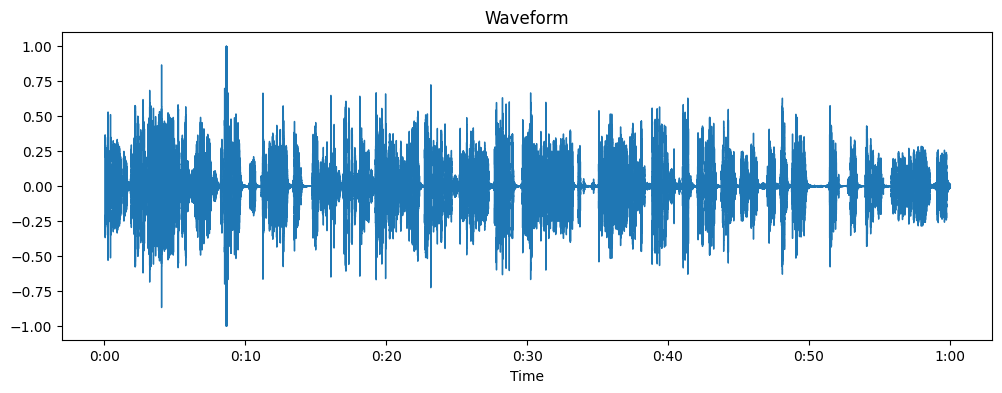

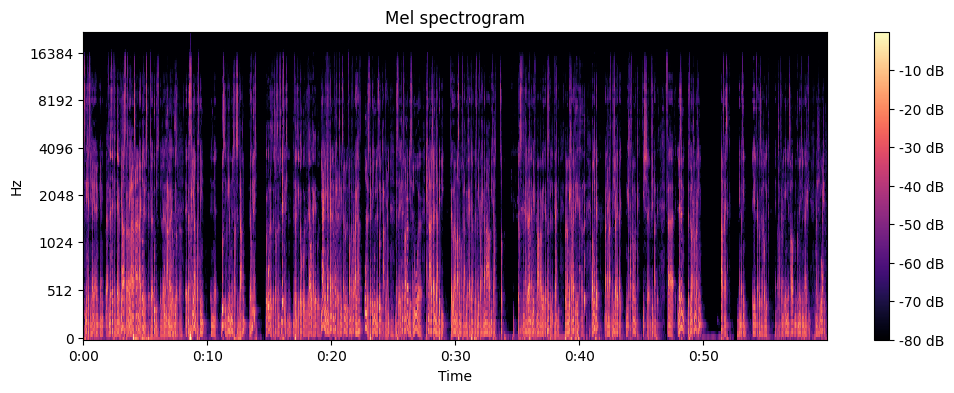

In [6]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load an audio file
file_path = "/content/drive/MyDrive/embeddings/segmented/masry/عصر اقتصاد السبوبة مع صلاح ابو المجد مع البودكاسترز_trimmed.wav_segment_1.wav"
y, sr = librosa.load(file_path, sr=None)

# Display the waveform
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.show()

# Compute the mel spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

# Display the mel spectrogram
plt.figure(figsize=(12, 4))
librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.show()


In [15]:
!pip install tensorflow_io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 13.2 MB/s eta 0:00:00


In [10]:
from natsort import natsorted
import os
import librosa
import soundfile as sf

# MAKE ALL LENGTHS 1 MINUTE

tot = 0

def segment_audio(name,input_file, output_dir):
    global tot
    print(tot)
    # Load audio file
    audio, sr = librosa.load(input_file, sr=None)

    # Calculate total duration of the audio in seconds
    total_duration = librosa.get_duration(y=audio, sr=sr)

    # Define segment duration in seconds (1 minute)
    segment_duration = 60

    # Calculate the number of segments
    num_segments = int(total_duration // segment_duration)

    tot += num_segments

    # Extract and save each segment
    for i in range(num_segments):
        start_time = i * segment_duration
        end_time = (i + 1) * segment_duration
        segment = audio[int(start_time * sr):int(end_time * sr)]
        output_file = f"{output_dir}/{name}_segment_{i+1}.wav"
        sf.write(output_file, segment, sr)
        print(f"Segment {i+1} saved as {output_file}")


X = []
y = []

path = '/content/drive/MyDrive/trimmed/'
dialects = natsorted(os.listdir(path))
print(dialects)

for i,dialect in enumerate(dialects):
    tot = 0
    full_path = path + dialect
    audios = natsorted(os.listdir(full_path))
    for j,audio in enumerate(audios):
        if tot > 65:
            break
        wav_file = full_path + '/' + audio
        try:
            segment_audio(audio,wav_file, '/content/drive/MyDrive/embeddings/segmented/')
        except Exception as e:
            print(e)
            print("ERROR: ", dialect, " AUDIO: ", audio)
            print("CONTINUING...")
            continue

    print("DIALECT: ", dialect, " AUDIO: ", audio)
    print("FINISHED DIALECT: ", dialect)

['egyptian', 'fos7a']
0
Segment 1 saved as /content/drive/MyDrive/embeddings/segmented//عصر اقتصاد السبوبة مع صلاح ابو المجد مع البودكاسترز_trimmed.wav_segment_1.wav
Segment 2 saved as /content/drive/MyDrive/embeddings/segmented//عصر اقتصاد السبوبة مع صلاح ابو المجد مع البودكاسترز_trimmed.wav_segment_2.wav
Segment 3 saved as /content/drive/MyDrive/embeddings/segmented//عصر اقتصاد السبوبة مع صلاح ابو المجد مع البودكاسترز_trimmed.wav_segment_3.wav
Segment 4 saved as /content/drive/MyDrive/embeddings/segmented//عصر اقتصاد السبوبة مع صلاح ابو المجد مع البودكاسترز_trimmed.wav_segment_4.wav
Segment 5 saved as /content/drive/MyDrive/embeddings/segmented//عصر اقتصاد السبوبة مع صلاح ابو المجد مع البودكاسترز_trimmed.wav_segment_5.wav
Segment 6 saved as /content/drive/MyDrive/embeddings/segmented//عصر اقتصاد السبوبة مع صلاح ابو المجد مع البودكاسترز_trimmed.wav_segment_6.wav
Segment 7 saved as /content/drive/MyDrive/embeddings/segmented//عصر اقتصاد السبوبة مع صلاح ابو المجد مع البودكاسترز_trimmed.

In [17]:
# import tensorflow as tf
# import pickle
# import numpy as np
# from sklearn.model_selection import train_test_split

# # Load data
# with open('X.pkl', 'rb') as f:
#     X = pickle.load(f)

# with open('y.pkl', 'rb') as f:
#     y = pickle.load(f)

# # Convert to numpy arrays
# X = np.array(X)
# y = np.array(y)

# # Convert labels to one-hot encoding
# num_classes = 3
# y = tf.keras.utils.to_categorical(y, num_classes)

# # Split data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Reshape input data for DenseNet
# X_train = X_train.reshape(X_train.shape[0], 124, 1024, 1)
# X_test = X_test.reshape(X_test.shape[0], 124, 1024, 1)

# # Create DenseNet model
# model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(124, 1024, 1), dtype=tf.float32, name='input_embedding'),
#     tf.keras.layers.Conv2D(3, (1, 1)),  # Convert to 3 channels for DenseNet
#     tf.keras.applications.DenseNet121(include_top=False, weights='imagenet', pooling='avg'),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dense(3, activation='softmax')
# ], name='densenet_model')

# # Compile the model
# METRICS = [
#     'accuracy',
#     tf.keras.metrics.Precision(name='precision'),
#     tf.keras.metrics.Recall(name='recall')
# ]

# model.compile(optimizer='Adam',
#               loss='categorical_crossentropy',
#               metrics=METRICS)

# # Train the model
# EPOCHS = 10
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=EPOCHS//3, restore_best_weights=True)
# history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), batch_size=64, callbacks=[early_stopping])


FileNotFoundError: [Errno 2] No such file or directory: 'X.pkl'